Module Description:
-------------------
Baseline code to create a dataset that has extracted skills, levels, Task Abilities, Knowledge, and Taxonomy Mapping.

Ownership:
----------
Project: Leveraging Artificial intelligence for Skills Extraction and Research (LAiSER)

Owner:  

        George Washington University Insitute of Public Policy
        Program on Skills, Credentials and Workforce Policy
        Media and Public Affairs Building
        805 21st Street NW
        Washington, DC 20052
        PSCWP@gwu.edu
        https://gwipp.gwu.edu/program-skills-credentials-workforce-policy-pscwp

License:
--------
Copyright 2024 George Washington University Insitute of Public Policy

Permission is hereby granted, free of charge, to any person obtaining a copy of this software and associated documentation files
(the “Software”), to deal in the Software without restriction, including without limitation the rights to use, copy, modify,
merge, publish, distribute, sublicense, and/or sell copies of the Software, and to permit persons to whom the Software is
furnished to do so, subject to the following conditions:

The above copyright notice and this permission notice shall be included in all copies or substantial portions of the Software.

THE SOFTWARE IS PROVIDED “AS IS”, WITHOUT WARRANTY OF ANY KIND, EXPRESS OR IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES
OF MERCHANTABILITY, FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL THE AUTHORS OR COPYRIGHT HOLDERS BE
LIABLE FOR ANY CLAIM, DAMAGES OR OTHER LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING FROM, OUT OF OR
IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER DEALINGS IN THE SOFTWARE.

Revision History:
-----------------
Rev No. | Date | Author | Description

---
[1.0.0] | 1/20/2025 | Prudhvi Chekuri | Baseline
[1.0.1] | 1/20/2025 | Prudhvi Chekuri | Generic prompt support for different inputs

# Environment Setup

## Install Packages

In [1]:
!pip install vllm triton -q

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 264.3/264.3 MB 7.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 96.5/96.5 kB 4.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 71.6/71.6 kB 5.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 111.0/111.0 kB 8.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 87.6/87.6 kB 7.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.7/16.7 MB 97.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 2.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 100.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 74.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 59.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 10.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56

In [2]:
!pip install -U bitsandbytes -q

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 69.7/69.7 MB 30.0 MB/s eta 0:00:00


## Imports

You need a HuggingFace access token to run below code. You can refer to laiser docs if you have any difficulty in setting up HuggingFace.

In [3]:
import re
import gc
import torch
import pandas as pd

import triton
from vllm import LLM
from tqdm import tqdm
from vllm import SamplingParams

import os
from google.colab import userdata
os.environ["HF_TOKEN"] = userdata.get('HF_TOKEN') # Add your HuggingFace access token and name it as HF_TOKEN

INFO 02-07 17:49:50 __init__.py:190] Automatically detected platform cuda.


Running the pipeline on a sample preprocessed syllabi data.

In [4]:
# # Load the sample syllabi data
# syllabi_data = pd.read_csv("https://raw.githubusercontent.com/LAiSER-Software/datasets/refs/heads/master/syllabi-data/preprocessed_50_opensyllabus_syllabi_data.csv")
# syllabi_data.head()

In [ ]:
# Load the sample job data
job_data = pd.read_csv("https://raw.githubusercontent.com/LAiSER-Software/datasets/refs/heads/master/jobs-data/linkedin_jobs_sample_36rows.csv")
job_data.head()

,Unnamed: 0.1,Unnamed: 0,system_job_id,file_name,file_id,source_state,expired,expired_date,date_compiled,created_date,...,application_method_1,application_method_2,application_method_3,application_method_4,application_method_text_1,application_method_text_2,application_method_text_3,application_method_text_4,description,job_id
0,0,0,5109722,TX_JCJobs.xml,NaN,NaN,1,2016-01-15 00:00:00+00:00,2016-01-01 00:00:00+00:00,2016-01-01 00:00:00+00:00,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Req ID: 29534BR\n\nPOSITION SUMMARY\n\nThis po...,69322097
1,1,1,5688866,TX_StateJobs.xml,NaN,NaN,1,2016-01-06 00:00:00+00:00,2016-01-01 00:00:00+00:00,2016-01-01 00:00:00+00:00,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Enters data using computer applications. Assis...,70014023
2,2,2,5974087,TX_JCJobs.xml,NaN,NaN,1,2016-02-17 00:00:00+00:00,2016-01-01 00:00:00+00:00,2016-01-01 00:00:00+00:00,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"Kforce has a client in Austin, Texas (TX) that...",70241308
3,3,3,6230051,TX_JCJobs.xml,NaN,NaN,1,2016-02-02 00:00:00+00:00,2016-01-01 00:00:00+00:00,2016-01-01 00:00:00+00:00,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"*We believe that*, when done right, investing ...",70543388
4,4,4,6230127,TX_JCJobs.xml,NaN,NaN,1,2016-01-12 00:00:00+00:00,2016-01-01 00:00:00+00:00,2016-01-01 00:00:00+00:00,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,**Description:** \nBaylor St. Luke’s Medical ...,70543468


## Load Model with vLLM

Using vLLM for faster inference.

In [6]:
# Use quantization to reduce the model size and memory usage
llm = LLM(model="hugging-quants/gemma-2-9b-it-AWQ-INT4", dtype="float16", quantization='awq')

config.json:   0%|          | 0.00/1.23k [00:00<?, ?B/s]

WARNING 02-07 17:49:54 config.py:2386] Casting torch.bfloat16 to torch.float16.
INFO 02-07 17:50:07 config.py:542] This model supports multiple tasks: {'embed', 'classify', 'reward', 'score', 'generate'}. Defaulting to 'generate'.
INFO 02-07 17:50:08 awq_marlin.py:115] Detected that the model can run with awq_marlin, however you specified quantization=awq explicitly, so forcing awq. Use quantization=awq_marlin for faster inference
WARNING 02-07 17:50:08 config.py:621] awq quantization is not fully optimized yet. The speed can be slower than non-quantized models.
INFO 02-07 17:50:08 llm_engine.py:234] Initializing a V0 LLM engine (v0.7.2) with config: model='hugging-quants/gemma-2-9b-it-AWQ-INT4', speculative_config=None, tokenizer='hugging-quants/gemma-2-9b-it-AWQ-INT4', skip_tokenizer_init=False, tokenizer_mode=auto, revision=None, override_neuron_config=None, tokenizer_revision=None, trust_remote_code=False, dtype=torch.float16, max_seq_len=8192, download_dir=None, load_format=LoadFo

tokenizer_config.json:   0%|          | 0.00/47.0k [00:00<?, ?B/s]

tokenizer.model:   0%|          | 0.00/4.24M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/34.4M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/636 [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/189 [00:00<?, ?B/s]

INFO 02-07 17:50:12 cuda.py:230] Using Flash Attention backend.
INFO 02-07 17:50:13 model_runner.py:1110] Starting to load model hugging-quants/gemma-2-9b-it-AWQ-INT4...
INFO 02-07 17:50:13 weight_utils.py:252] Using model weights format ['*.safetensors']


model-00001-of-00002.safetensors:   0%|          | 0.00/5.00G [00:00<?, ?B/s]

model-00002-of-00002.safetensors:   0%|          | 0.00/1.16G [00:00<?, ?B/s]

model.safetensors.index.json:   0%|          | 0.00/87.1k [00:00<?, ?B/s]

Loading safetensors checkpoint shards:   0% Completed | 0/2 [00:00<?, ?it/s]


INFO 02-07 17:52:16 model_runner.py:1115] Loading model weights took 5.7838 GB
INFO 02-07 17:52:23 worker.py:267] Memory profiling takes 6.91 seconds
INFO 02-07 17:52:23 worker.py:267] the current vLLM instance can use total_gpu_memory (39.56GiB) x gpu_memory_utilization (0.90) = 35.60GiB
INFO 02-07 17:52:23 worker.py:267] model weights take 5.78GiB; non_torch_memory takes 0.09GiB; PyTorch activation peak memory takes 2.38GiB; the rest of the memory reserved for KV Cache is 27.34GiB.
INFO 02-07 17:52:23 executor_base.py:110] # CUDA blocks: 5333, # CPU blocks: 780
INFO 02-07 17:52:23 executor_base.py:115] Maximum concurrency for 8192 tokens per request: 10.42x
INFO 02-07 17:52:26 model_runner.py:1434] Capturing cudagraphs for decoding. This may lead to unexpected consequences if the model is not static. To run the model in eager mode, set 'enforce_eager=True' or use '--enforce-eager' in the CLI. If out-of-memory error occurs during cudagraph capture, consider decreasing `gpu_memory_util

Capturing CUDA graph shapes: 100%|██████████| 35/35 [00:34<00:00,  1.02it/s]

INFO 02-07 17:53:00 model_runner.py:1562] Graph capturing finished in 34 secs, took 0.57 GiB
INFO 02-07 17:53:00 llm_engine.py:431] init engine (profile, create kv cache, warmup model) took 44.66 seconds


## Utils

In [7]:
prompt_template = """<start_of_turn>user
**Objective:** Given a {input_desc}, complete the following tasks with structured outputs.

### Tasks:
1. **Skills Extraction:** Identify {num_key_skills} key skills mentioned in the {input_desc}.
   - Extract skill keywords or phrases of no more than three words.

2. **Skill Level Assignment:** Assign a proficiency level to each extracted skill based on the SCQF Level Descriptors (see below).

3. **Knowledge Required:** For each skill, list {num_key_kr} broad areas of understanding or expertise necessary to develop the skill.

4. **Task Abilities:** For each skill, list {num_key_tas} general tasks or capabilities enabled by the skill.

### Guidelines:
- **Skill Extraction:** Identify skills explicitly stated or implied through {input_desc}.
- **Skill Level Assignment:** Use the SCQF Level Descriptors to classify proficiency:
  - 1: Basic awareness of simple concepts.
  - 2: Limited operational understanding, guided application.
  - 3: Moderate knowledge, supervised application of techniques.
  - 4: Clear understanding, independent work in familiar contexts.
  - 5: Advanced knowledge, autonomous problem-solving.
  - 6: Specialized knowledge, critical analysis within defined areas.
  - 7: Advanced specialization, leadership in problem-solving.
  - 8: Expert knowledge, innovation in complex contexts.
  - 9: Highly specialized expertise, contributing original thought.
  - 10: Sustained mastery, influential in areas of specialization.
  - 11: Groundbreaking innovation, professional or academic mastery.
  - 12: Global expertise, leading advancements at the highest level.

- **Knowledge and Task Abilities:**
  - **Knowledge Required:** Broad areas, e.g., "data visualization techniques."
  - **Task Abilities:** General tasks or capabilities, e.g., "data analysis."
  - Each item in these two lists should be no more than three words.
  - Avoid overly specific or vague terms.

### Answer Format:
- Use this format strictly in the response:
  -> Skill: [Skill Name], Level: [1–12], Knowledge Required: [list], Task Abilities: [list].

{input_text}

**Response:** Provide only the requested structured information without additional explanations.

<end_of_turn>
<start_of_turn>model
"""

In [8]:
def create_prompt(query, input_type, num_key_skills, num_key_kr, num_key_tas):
    input_desc = "job description" if input_type == "syllabi" else "course syllabus description and its learning outcomes"

    if input_type == "syllabi":
        input_text = f"""### Input:\n**Course Description:** {query["description"]}\n**Learning Outcomes:** {query["learning_outcomes"]}"""
    else:
        input_text = f"""### Input:\n{query["description"]}"""

    prompt = prompt_template.format(input_desc=input_desc, num_key_skills=num_key_skills, num_key_kr=num_key_kr, num_key_tas=num_key_tas, input_text=input_text)
    return prompt

## Inference

In [9]:
def vllm_batch_generate(queries, input_type, batch_size=32, num_key_skills=5, num_key_kr='3-5', num_key_tas='3-5'):

    result = []

    sampling_params = SamplingParams(max_tokens=1000)

    for i in range(0, len(queries), batch_size):
        prompts = [create_prompt(queries.iloc[i], input_type, num_key_skills, num_key_kr, num_key_tas) for i in range(i, min(i+batch_size, len(queries)))]
        output = llm.generate(prompts, sampling_params=sampling_params)

        result.extend(output)

    return result

In [10]:
result = vllm_batch_generate(job_data, input_type="Jobs", batch_size=64)

Processed prompts:   0%|          | 0/64 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

WARNING 02-07 17:53:09 scheduler.py:1560] Sequence group 63 is preempted by PreemptionMode.RECOMPUTE mode because there is not enough KV cache space. This can affect the end-to-end performance. Increase gpu_memory_utilization or tensor_parallel_size to provide more KV cache memory. total_num_cumulative_preemption=1


Processed prompts:   0%|          | 0/64 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

WARNING 02-07 18:00:37 scheduler.py:1560] Sequence group 1407 is preempted by PreemptionMode.RECOMPUTE mode because there is not enough KV cache space. This can affect the end-to-end performance. Increase gpu_memory_utilization or tensor_parallel_size to provide more KV cache memory. total_num_cumulative_preemption=51


Processed prompts:   0%|          | 0/64 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

WARNING 02-07 18:08:13 scheduler.py:1560] Sequence group 2745 is preempted by PreemptionMode.RECOMPUTE mode because there is not enough KV cache space. This can affect the end-to-end performance. Increase gpu_memory_utilization or tensor_parallel_size to provide more KV cache memory. total_num_cumulative_preemption=101


Processed prompts:   2%|▏         | 1/64 [00:09<10:04,  9.60s/it, est. speed input: 65.30 toks/s, output: 4.17 toks/s]

WARNING 02-07 18:15:37 scheduler.py:1560] Sequence group 4028 is preempted by PreemptionMode.RECOMPUTE mode because there is not enough KV cache space. This can affect the end-to-end performance. Increase gpu_memory_utilization or tensor_parallel_size to provide more KV cache memory. total_num_cumulative_preemption=151


Processed prompts: 100%|██████████| 8/8 [00:04<00:00,  1.60it/s, est. speed input: 1915.93 toks/s, output: 295.71 toks/s]


In [11]:
print(result[0].prompt)

<start_of_turn>user
**Objective:** Given a course syllabus description and its learning outcomes, complete the following tasks with structured outputs.

### Tasks:
1. **Skills Extraction:** Identify 5 key skills mentioned in the course syllabus description and its learning outcomes.
   - Extract skill keywords or phrases of no more than three words.

2. **Skill Level Assignment:** Assign a proficiency level to each extracted skill based on the SCQF Level Descriptors (see below).

3. **Knowledge Required:** For each skill, list 3-5 broad areas of understanding or expertise necessary to develop the skill.

4. **Task Abilities:** For each skill, list 3-5 general tasks or capabilities enabled by the skill.

### Guidelines:
- **Skill Extraction:** Identify skills explicitly stated or implied through course syllabus description and its learning outcomes.
- **Skill Level Assignment:** Use the SCQF Level Descriptors to classify proficiency:
  - 1: Basic awareness of simple concepts.
  - 2: Lim

In [12]:
print(result[0].outputs[0].text)

-> Skill: Curriculum Design, Level: 4, Knowledge Required: Training principles, Learning methods, Subject matter expertise, Task Abilities: Develop training plans, Create instructional materials, Facilitate learning sessions.
-> Skill: Technical Knowledge, Level: 4, Knowledge Required: Product functionality, System operations, Data analysis, Task Abilities: Troubleshoot technical issues, Explain procedures, Provide technical support.
-> Skill: Communication Skills, Level: 4, Knowledge Required: Interpersonal communication, Presentation skills, Active listening, Task Abilities: Explain complex information, Engage with trainees, Build rapport.
-> Skill: Adult Learning, Level: 3, Knowledge Required: Learning theories, Instructional design, Feedback mechanisms, Task Abilities: Adapt content to learner needs, Facilitate group discussions, Assess learning outcomes. 
-> Skill: Collaboration, Level: 4, Knowledge Required: Teamwork principles, Conflict resolution, Shared goals, Task Abilities: 

## Parse LLM Responses

Extract all the required information from the LLM output.

In [13]:
def parse_output(response):

    out = []
    items = [i.replace('\n', '') for i in response.strip('->').strip().split('->')]

    for item in items:
        skill_data = {}

        # Extract skill
        skill_match = re.search(r"Skill:\s*([^,]+)", item)
        if skill_match:
            skill_data['Skill'] = skill_match.group(1).strip()

        # Extract level
        level_match = re.search(r"Level:\s*(\d+)", item)
        if level_match:
            skill_data['Level'] = int(level_match.group(1).strip())

        # Extract knowledge required
        knowledge_match = re.search(r"Knowledge Required:\s*([^,]+(?:, [^:]+)*?)\s*(?:Task Abilities|$)", item)
        if knowledge_match:
            knowledge_raw = knowledge_match.group(1)
            skill_data['Knowledge Required'] = [k.strip() for k in knowledge_raw.strip().strip(',').split(',')]

        # Extract task abilities
        task_match = re.search(r"Task Abilities:\s*([^,]+(?:, [^:]+)*)", item)
        if task_match:
            task_raw = task_match.group(1)
            skill_data['Task Abilities'] = [t.strip() for t in task_raw.split(',')]

        out.append(skill_data)

    return out

In [15]:
# parsed_output = []
# for i in range(len(result)):
#     parsed = parse_output(result[i].outputs[0].text)
#     for item in parsed:
#         item['id'] = syllabi_data.iloc[i]['id']
#         item['description'] = syllabi_data.iloc[i]['description']
#         item['learning_outcomes'] = syllabi_data.iloc[i]['learning_outcomes']
#     parsed_output.extend(parsed)

parsed_output = []
for i in range(len(result)):
    parsed = parse_output(result[i].outputs[0].text)
    for item in parsed:
        item['id'] = job_data.iloc[i]['job_id']
        item['description'] = job_data.iloc[i]['description']
    parsed_output.extend(parsed)

In [17]:
len(job_data), len(parsed_output)

(5000, 24083)

In [18]:
parsed_output[0]

{'Skill': 'Curriculum Design',
 'Level': 4,
 'Knowledge Required': ['Training principles',
  'Learning methods',
  'Subject matter expertise'],
 'Task Abilities': ['Develop training plans',
  'Create instructional materials',
  'Facilitate learning sessions.'],
 'id': 69322097,
 'description': "Req ID: 29534BR\n\nPOSITION SUMMARY\n\nThis position is open to any ASO location listed and will consider existing internal WAH employees in any area\n\nWill only consider External candidates located near the Phoenix office location listed in posting.\n\nThis trainer position will be a technical training position for the Aetna Medicaid Provider Data Services teams, including HPRA, CSS, RCAR, MPST, Testing and Provider Maintenance. This position will report directly into the Medicaid Service Operations team, not Learning and Performance.\n\nFundamental Components:\n-Responsible for the creation of the training curriculum from ground up for the Aetna Medicaid Provider Data Services teams, includin

## Create DataFrame

In [20]:
extracted_df = pd.DataFrame(parsed_output)
extracted_df = extracted_df[["id", "description", "Skill", "Level", "Knowledge Required", "Task Abilities"]]
extracted_df

,id,description,Skill,Level,Knowledge Required,Task Abilities
0,69322097,Req ID: 29534BR\n\nPOSITION SUMMARY\n\nThis po...,Curriculum Design,4.0,"[Training principles, Learning methods, Subjec...","[Develop training plans, Create instructional ..."
1,69322097,Req ID: 29534BR\n\nPOSITION SUMMARY\n\nThis po...,Technical Knowledge,4.0,"[Product functionality, System operations, Dat...","[Troubleshoot technical issues, Explain proced..."
2,69322097,Req ID: 29534BR\n\nPOSITION SUMMARY\n\nThis po...,Communication Skills,4.0,"[Interpersonal communication, Presentation ski...","[Explain complex information, Engage with trai..."
3,69322097,Req ID: 29534BR\n\nPOSITION SUMMARY\n\nThis po...,Adult Learning,3.0,"[Learning theories, Instructional design, Feed...","[Adapt content to learner needs, Facilitate gr..."
4,69322097,Req ID: 29534BR\n\nPOSITION SUMMARY\n\nThis po...,Collaboration,4.0,"[Teamwork principles, Conflict resolution, Sha...","[Work with stakeholders, Gather input, Build c..."
...,...,...,...,...,...,...
24078,79384927,The Enterprise Data Architect defines the visi...,Data Governance,6.0,"[policy frameworks, data standards, stakeholde...","[develop policies, implement controls, ensure ..."
24079,79384927,The Enterprise Data Architect defines the visi...,Data Modeling,4.0,"[database design, ER diagrams, data normalizat...","[build data models, design databases, optimize..."
24080,79384927,The Enterprise Data Architect defines the visi...,Data Integration,4.0,"[ETL processes, data transformation, middlewar...","[connect data sources, consolidate data, creat..."
24081,79384927,The Enterprise Data Architect defines the visi...,Business Intelligence,4.0,"[data visualization, reporting tools, analytic...","[create reports, analyze data, generate insigh..."


# Taxonomy Crosswalk

Map the extracted data with the ESCO Taxonomy.

In [21]:
import spacy
import numpy as np
from tqdm import tqdm
from scipy.spatial.distance import cdist

import spacy.cli
spacy.cli.download("en_core_web_lg")

✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_lg')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.


In [22]:
esco_df = pd.read_csv("https://raw.githubusercontent.com/LAiSER-Software/datasets/refs/heads/master/taxonomies/ESCO_skills_Taxonomy.csv")
esco_df.head()

,conceptType,conceptUri,skillType,reuseLevel,preferredLabel,altLabels,hiddenLabels,status,modifiedDate,scopeNote,definition,inScheme,description
0,KnowledgeSkillCompetence,http://data.europa.eu/esco/skill/0005c151-5b5a...,skill/competence,sector-specific,manage musical staff,manage staff of music\ncoordinate duties of mu...,NaN,released,2023-11-30T15:53:37.136Z,NaN,NaN,http://data.europa.eu/esco/concept-scheme/skil...,Assign and manage staff tasks in areas such as...
1,KnowledgeSkillCompetence,http://data.europa.eu/esco/skill/00064735-8fad...,skill/competence,occupation-specific,supervise correctional procedures,oversee prison procedures\nmanage correctional...,NaN,released,2023-11-30T15:04:00.689Z,NaN,NaN,http://data.europa.eu/esco/concept-scheme/memb...,Supervise the operations of a correctional fac...
2,KnowledgeSkillCompetence,http://data.europa.eu/esco/skill/000709ed-2be5...,skill/competence,sector-specific,apply anti-oppressive practices,apply non-oppressive practices\napply an anti-...,NaN,released,2023-11-28T10:45:53.54Z,NaN,NaN,http://data.europa.eu/esco/concept-scheme/skil...,"Identify oppression in societies, economies, c..."
3,KnowledgeSkillCompetence,http://data.europa.eu/esco/skill/0007bdc2-dd15...,skill/competence,sector-specific,control compliance of railway vehicles regulat...,monitoring of compliance with railway vehicles...,NaN,released,2023-11-30T16:29:18.273Z,NaN,NaN,http://data.europa.eu/esco/concept-scheme/skil...,"Inspect rolling stock, components and systems ..."
4,KnowledgeSkillCompetence,http://data.europa.eu/esco/skill/00090cc1-1f27...,skill/competence,cross-sector,identify available services,establish available services\ndetermine rehabi...,NaN,released,2023-11-28T10:38:49.206Z,NaN,NaN,http://data.europa.eu/esco/concept-scheme/memb...,Identify the different services available for ...


In [25]:
def get_embedding(nlp, input_text):
    """
    Creates vector embeddings for input text based on nlp object

    Parameters
    ----------
    nlp : object of spacy nlp model
    input_text : text
        Provide text to be vectorized, usually skill, extracted of referenced

    Returns
    -------
    numpy array of vectorized text


    """
    input_text = str(input_text)
    doc = nlp(input_text)
    if len(doc) == 0:
        return np.zeros(300)  # Return zeros for empty texts
    return np.mean([word.vector for word in doc], axis=0)

nlp = spacy.load("en_core_web_lg")
esco_skill_embeddings = np.array([get_embedding(nlp, label) for label in esco_df['preferredLabel']])

/usr/local/lib/python3.11/dist-packages/spacy/util.py:1740: UserWarning: [W111] Jupyter notebook detected: if using `prefer_gpu()` or `require_gpu()`, include it in the same cell right before `spacy.load()` to ensure that the model is loaded on the correct device. More information: http://spacy.io/usage/v3#jupyter-notebook-gpu
  warnings.warn(Warnings.W111)


In [31]:
matches = []

raw_skill_embeddings = np.array([get_embedding(nlp, skill) for skill in extracted_df['Skill']])

# Calculate cosine similarities in bulk
similarities = 1 - cdist(raw_skill_embeddings, esco_skill_embeddings, metric='cosine')

for i, raw_skill in tqdm(enumerate(extracted_df['Skill'])):
    skill_matches = np.where(similarities[i] > 0.85)[0]
    for match in skill_matches:
        matches.append({
            "Research ID": extracted_df.iloc[i]['id'],
            "Description": extracted_df.iloc[i]['description'],
            "Raw Skill": raw_skill,
            "Level": extracted_df.iloc[i]['Level'],
            "Knowledge Required": extracted_df.iloc[i]['Knowledge Required'],
            "Task Abilities": extracted_df.iloc[i]['Task Abilities'],
            "Skill Tag": f"ESCO.{match}",
            "Correlation Coefficient": similarities[i, match]
        })

mapped_df = pd.DataFrame(columns=['Research ID', 'Description', 'Raw Skill', 'Level', 'Knowledge Required', 'Task Abilities', 'Skill Tag', 'Correlation Coefficient'])
mapped_df = mapped_df._append(matches, ignore_index=True)

KeyboardInterrupt: 

## Final Dataset

In [32]:
mapped_df

,Research ID,Description,Raw Skill,Level,Knowledge Required,Task Abilities,Skill Tag,Correlation Coefficient
0,70014023,Enters data using computer applications. Assis...,Data Entry,2.0,"[computer applications, input data, file manag...","[data input, record keeping, basic troubleshoo...",ESCO.3226,0.873558
1,70014023,Enters data using computer applications. Assis...,Data Entry,2.0,"[computer applications, input data, file manag...","[data input, record keeping, basic troubleshoo...",ESCO.3637,0.885755
2,70241308,"Kforce has a client in Austin, Texas (TX) that...",Data Analysis,4.0,"[financial data, data migration techniques, da...","[data consolidation, data interpretation, data...",ESCO.3226,0.907012
3,70241308,"Kforce has a client in Austin, Texas (TX) that...",Data Analysis,4.0,"[financial data, data migration techniques, da...","[data consolidation, data interpretation, data...",ESCO.3637,0.925421
4,70241308,"Kforce has a client in Austin, Texas (TX) that...",Data Analysis,4.0,"[financial data, data migration techniques, da...","[data consolidation, data interpretation, data...",ESCO.12451,0.878007
...,...,...,...,...,...,...,...,...
70872,79384927,The Enterprise Data Architect defines the visi...,Data Integration,4.0,"[ETL processes, data transformation, middlewar...","[connect data sources, consolidate data, creat...",ESCO.3226,0.936385
70873,79384927,The Enterprise Data Architect defines the visi...,Data Integration,4.0,"[ETL processes, data transformation, middlewar...","[connect data sources, consolidate data, creat...",ESCO.3637,0.991507
70874,79384927,The Enterprise Data Architect defines the visi...,Data Integration,4.0,"[ETL processes, data transformation, middlewar...","[connect data sources, consolidate data, creat...",ESCO.12451,0.910947
70875,79384927,The Enterprise Data Architect defines the visi...,Data Integration,4.0,"[ETL processes, data transformation, middlewar...","[connect data sources, consolidate data, creat...",ESCO.13533,0.875947


## Save Datasets

In [33]:
extracted_df.to_csv("final_df_job.csv", index = False)
mapped_df.to_csv("extracted_job.csv", index = False)

In [ ]:
# mapped_df  = pd.read_csv("https://raw.githubusercontent.com/LAiSER-Software/laiser-bootcamp/refs/heads/main/extracted.csv")

In [34]:
from itertools import combinations
from collections import Counter

# Group by Research ID (job description or syllabus) and list skills
skill_groups = mapped_df.groupby("Research ID")["Raw Skill"].apply(list)

# Count skill co-occurrences
skill_pairs = []
for skills in skill_groups:
    skill_pairs.extend(combinations(set(skills), 2))  # Avoid duplicate skills in the same job description

co_occurrence_counts = Counter(skill_pairs)

# Convert to DataFrame
co_occurrence_df = pd.DataFrame(co_occurrence_counts.items(), columns=["Skill Pair", "Count"])
co_occurrence_df[["Skill A", "Skill B"]] = co_occurrence_df["Skill Pair"].apply(pd.Series)
co_occurrence_df.drop(columns=["Skill Pair"], inplace=True)

# Display first few rows
print(co_occurrence_df.head())


   Count              Skill A          Skill B
0     97  Attention to Detail     Organization
1    177  Attention to Detail    Communication
2    123  Attention to Detail  Data Collection
3    276         Organization    Communication
4    130         Organization  Data Collection


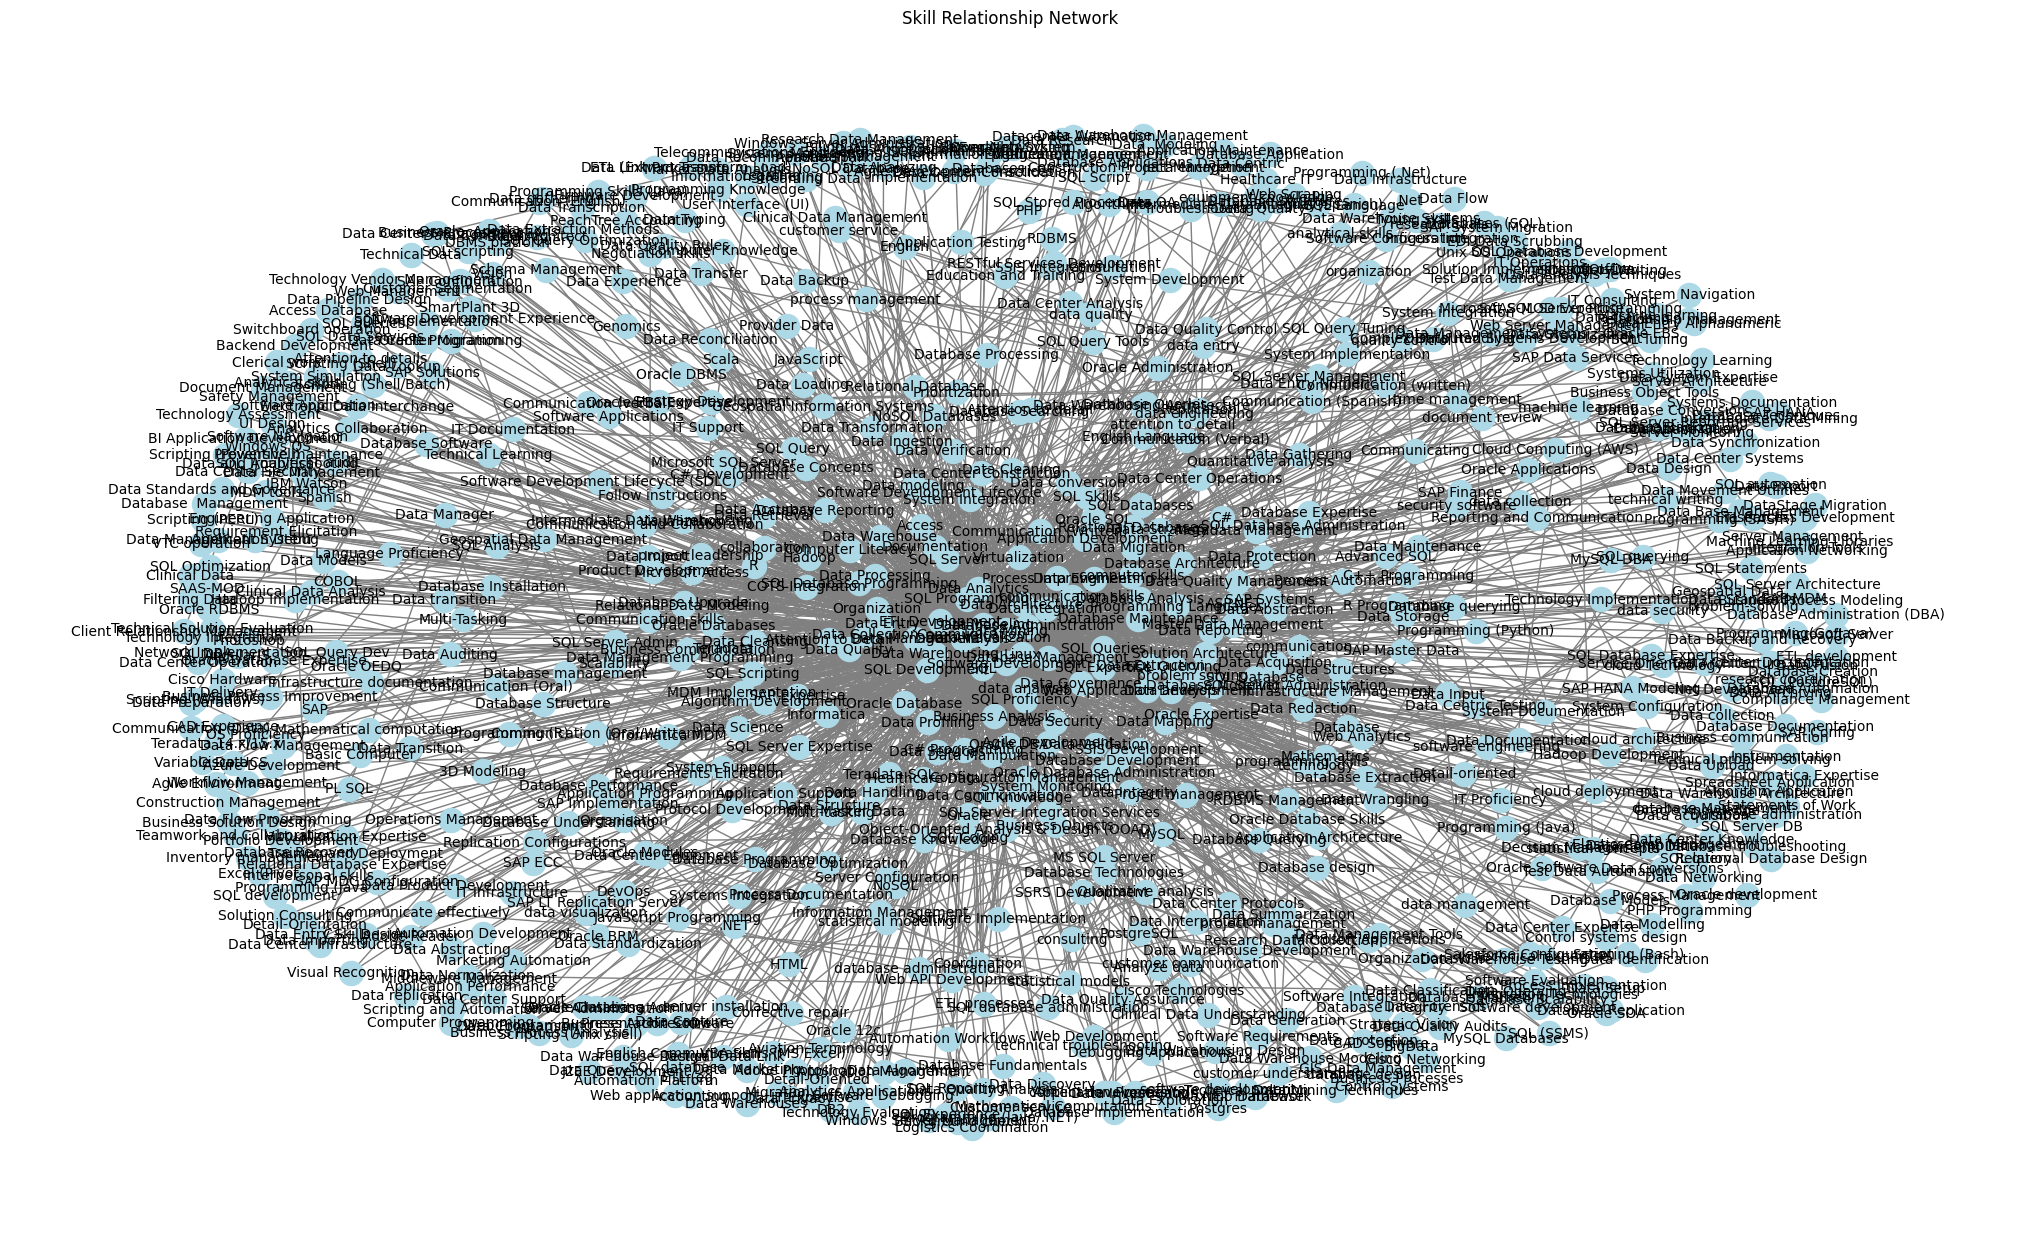

In [37]:
import networkx as nx
import matplotlib.pyplot as plt

# Build a graph
G = nx.Graph()

# Add edges to the graph
for _, row in co_occurrence_df.iterrows():
    G.add_edge(row["Skill A"], row["Skill B"], weight=row["Count"])

# Plot the graph
plt.figure(figsize=(20, 12))
pos = nx.spring_layout(G, k=0.5)  # Positioning of nodes
nx.draw(G, pos, with_labels=True, node_size=300, node_color="lightblue", edge_color="gray", font_size=10)
plt.title("Skill Relationship Network")
plt.show()


In [38]:
pip install networkx pyvis


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 756.0/756.0 kB 14.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 60.6 MB/s eta 0:00:00


In [39]:
import networkx as nx
import pandas as pd
from pyvis.network import Network

# Load extracted skills data
df = pd.read_csv("")  # Replace with job descriptions if needed

# Initialize Graph
G = nx.DiGraph()  # Directed graph for prerequisite relationships

# Add nodes (skills)
skills = set(df["Skill Tag"].dropna().unique())
for skill in skills:
    G.add_node(skill, label=skill)

# Establish relationships using co-occurrence (example)
from itertools import combinations

# Group skills by syllabus or job posting
skill_groups = df.groupby("Research ID")["Skill Tag"].apply(list)

for skills in skill_groups:
    for skill1, skill2 in combinations(set(skills), 2):
        if G.has_edge(skill1, skill2):
            G[skill1][skill2]['weight'] += 1  # Increase weight if already exists
        else:
            G.add_edge(skill1, skill2, weight=1, relation="co-occurs")  # Default relation

# Convert relationships into a DataFrame
edges_data = pd.DataFrame([(u, v, d['weight']) for u, v, d in G.edges(data=True)],
                           columns=["Skill A", "Skill B", "Weight"])
print(edges_data.head())


FileNotFoundError: [Errno 2] No such file or directory: 'extracted_skills_for_sample_syllabus.csv'